# MANN

In [1]:
# Ignore InterpolationMode warnings from torchmeta
import warnings
warnings.filterwarnings("ignore")

## Imports

In [2]:
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torchmeta.datasets import Omniglot
from torchmeta.transforms import Categorical, ClassSplitter, Rotation
from torchvision.transforms import Compose, Resize, ToTensor, InterpolationMode
from torchmeta.utils.data import BatchMetaDataLoader

In [3]:
seed = 42
np.random.seed(seed);
torch.manual_seed(seed);

## Classes

A Neural Turing Machine (NTM) consists of many parts. We modularize them by creating multiple classes corresponding to each part of the NTM.

![NTM Architecture](images/ntm_architecture.png)

From Figure 1 of Graves et al. (2014) [[1]](#cite-ntm)

### Memory

Let $\mathbf{M}_t$ be the content of the $N \times M$ memory matrix at time $t$.
- $N$ is the number of memory locations.
- $M$ is the vector size of each location.

---
From Section 3.1 of Graves et al. (2014) [[1]](#cite-ntm)

In [4]:
class Memory(nn.Module):
    def __init__(self, size):
        """
        The memory for the Neural Turing Machine stored as a matrix.

        Each batch has its own memory matrix, so the memory's dimension is (batch_size, N, M).

        Parameters
        ----------
        size : tuple
            A tuple (N, M) describing the shape of the matrix. N is the number of memory locations and M is the vector size for each location..

        Attributes
        ----------
        matrix : torch.FloatTensor
            The memory matrix of shape (batch_size, N, M).
        size : tuple
            A tuple (N, M) describing the shape of the matrix.
        """
        super(Memory, self).__init__()
        self.size = size

        # Initialize memory bias
        initial_state = torch.ones(self.size) * 1e-6
        self.register_buffer('initial_state', initial_state.data)

        # Initial read vector is a learnt parameter
        self.initial_read = nn.Parameter(torch.randn(1, self.size[1]) * 0.01)

    def reset(self, batch_size):
        self.matrix = self.initial_state.clone().repeat(batch_size, 1, 1)

    def get_initial_read(self, batch_size):
        return self.initial_read.clone().repeat(batch_size, 1)

    def write(self, w, e, a):
        self.matrix = self.matrix * (1 - torch.matmul(w.unsqueeze(-1), e.unsqueeze(1)))
        self.matrix = self.matrix + torch.matmul(w.unsqueeze(-1), a.unsqueeze(1))

### Read and Write Heads

The weighting $w_t$ used for reading and writing the memory is computed in a complex manner, described in the Figure below.

![NTM Weight Calculation](images/ntm_weight_calculation.png)

From Figure 2 of Graves et al. (2014) [[1]](#cite-ntm)

In [5]:
class Head(nn.Module):
    def __init__(self, memory, hidden_size):
        super(Head, self).__init__()
        self.memory = memory
        
        # Initialize layers: k, beta, g, s, gamma
        self.k_layer = nn.Linear(hidden_size, self.memory.size[1])
        self.beta_layer = nn.Linear(hidden_size, 1)
        self.g_layer = nn.Linear(hidden_size, 1)
        self.s_layer = nn.Linear(hidden_size, 3)
        self.gamma_layer = nn.Linear(hidden_size, 1)
        for layer in [self.k_layer, self.beta_layer, self.g_layer, self.s_layer, self.gamma_layer]:
            nn.init.xavier_uniform_(layer.weight, gain=1.4)
            nn.init.normal_(layer.bias, std=0.01)

        self._initial_state = nn.Parameter(torch.randn(1, self.memory.size[0]) * 1e-5)

    def get_initial_state(self, batch_size):
        # Softmax to ensure weights are normalized
        return F.softmax(self._initial_state, dim=1).repeat(batch_size, 1)

    def get_head_weight(self, x, previous_state, memory_matrix):
        # Generate controller outputs
        k = self.k_layer(x)
        beta = F.softplus(self.beta_layer(x))
        g = torch.sigmoid(self.g_layer(x))
        s = F.softmax(self.s_layer(x), dim=1)
        gamma = 1 + F.softplus(self.gamma_layer(x))

        # Focusing by content with k, beta
        w_c = F.softmax(beta * F.cosine_similarity(memory_matrix + 1e-16, k.unsqueeze(1) + 1e-16, dim=-1), dim=1)

        # Focusing by location with g
        w_g = g * w_c + (1 - g) * previous_state

        # Run circular convolution with s
        w_t = self._shift(w_g, s)
        
        # Sharpen weighting with gamma
        w = w_t ** gamma
        w = torch.div(w, torch.sum(w, dim=1).unsqueeze(1) + 1e-16)

        return w

    def _convolve(self, w, s):
        """Circular convolution implementation."""
        assert s.size(0) == 3
        t = torch.cat([w[-1:], w, w[:1]], dim=0)
        c = F.conv1d(t.view(1, 1, -1), s.view(1, 1, -1)).view(-1)
        return c

    def _shift(self, w_g, s):
        result = w_g.clone()
        for b in range(len(w_g)):
            result[b] = self._convolve(w_g[b], s[b])
        return result

In [6]:
class ReadHead(Head):
    def forward(self, x, previous_state):
        w = self.get_head_weight(x, previous_state, self.memory.matrix)
        return torch.matmul(w.unsqueeze(1), self.memory.matrix).squeeze(1), w

In [7]:
class WriteHead(Head):
    def __init__(self, memory, hidden_size):
        super(WriteHead, self).__init__(memory, hidden_size)

        # Initialize additional layers: e and a
        self.e_layer = nn.Linear(hidden_size, memory.size[1])
        self.a_layer = nn.Linear(hidden_size, memory.size[1])
        for layer in [self.e_layer, self.a_layer]:
            nn.init.xavier_uniform_(layer.weight, gain=1.4)
            nn.init.normal_(layer.bias, std=0.01)

    def forward(self, x, previous_state):
        w = self.get_head_weight(x, previous_state, self.memory.matrix)
        e = torch.sigmoid(self.e_layer(x))
        a = self.a_layer(x)

        self.memory.write(w, e, a)

        return w

### Controllers (FeedForward, LSTM)

In [8]:
class FeedForwardController(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(FeedForwardController, self).__init__()
        self.layer_1 = nn.Linear(input_size, hidden_size)
        self.layer_2 = nn.Linear(hidden_size, hidden_size)
        stdev = 5 / (np.sqrt(input_size + hidden_size))
        nn.init.uniform_(self.layer_1.weight, -stdev, stdev)
        nn.init.uniform_(self.layer_2.weight, -stdev, stdev)

    def forward(self, x, state):
        x1 = F.relu(self.layer_1(x))
        output = F.relu(self.layer_2(x1))
        return output, state

    def get_initial_state(self):
        return 0, 0

In [9]:
class LSTMController(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(LSTMController, self).__init__()
        self.layer = nn.LSTM(input_size=input_size, hidden_size=hidden_size)
        # The hidden state is a learned parameter
        self.lstm_h_state = nn.Parameter(torch.randn(1, 1, hidden_size) * 0.05)
        self.lstm_c_state = nn.Parameter(torch.randn(1, 1, hidden_size) * 0.05)
        for p in self.layer.parameters():
            if p.dim() == 1:
                nn.init.constant_(p, 0)
            else:
                stdev = 5 / (np.sqrt(input_size + hidden_size))
                nn.init.uniform_(p, -stdev, stdev)

    def forward(self, x, state):
        output, state = self.layer(x.unsqueeze(0), state)
        return output.squeeze(0), state

    def get_initial_state(self, batch_size):
        lstm_h = self.lstm_h_state.clone().repeat(1, batch_size, 1)
        lstm_c = self.lstm_c_state.clone().repeat(1, batch_size, 1)
        return lstm_h, lstm_c

### Neural Turing Machine

This is just the entire architecture encapsulated into a single module.

In [10]:
class NTM(nn.Module):
    def __init__(self, input_size, hidden_size, memory_size, lstm_controller=True):
        super(NTM, self).__init__()
        Controller = LSTMController if lstm_controller else FeedForwardController
        controller_input_size = input_size + memory_size[1]
        self.controller = Controller(controller_input_size, hidden_size)
        self.memory = Memory(memory_size)
        self.read_head = ReadHead(self.memory, hidden_size)
        self.write_head = WriteHead(self.memory, hidden_size)
        self.fc = nn.Linear(hidden_size + memory_size[1], 5)
        nn.init.xavier_uniform_(self.fc.weight, gain=1)
        nn.init.normal_(self.fc.bias, std=0.01)

    def get_initial_state(self, batch_size):
        self.memory.reset(batch_size)
        controller_state = self.controller.get_initial_state(batch_size)
        read = self.memory.get_initial_read(batch_size)
        read_head_state = self.read_head.get_initial_state(batch_size)
        write_head_state = self.write_head.get_initial_state(batch_size)

        return (read, read_head_state, write_head_state, controller_state)

    def forward(self, x, previous_state):
        previous_read, previous_read_head_state, previous_write_head_state, previous_controller_state = previous_state
        controller_input = torch.cat([x, previous_read], dim=1)
        controller_output, controller_state = self.controller(controller_input, previous_controller_state)
        read_head_output, read_head_state = self.read_head(controller_output, previous_read_head_state)
        write_head_state = self.write_head(controller_output, previous_write_head_state)
        fc_input = torch.cat((controller_output, read_head_output), dim=1)
        state = (read_head_output, read_head_state, write_head_state, controller_state)

        return F.softmax(self.fc(fc_input), dim=1), state

## Hyperparameters

### Omniglot Hyperparameters

In [11]:
# Number of classes
N_WAY = 5
# Number of images per class
N_SHOT = 5
# Size of the Omniglot image
IMAGE_SIZE = 20

![Hyperparameters](images/hyperparameters.png)

From Section 9 of Santoro et al. (2016) [[2]](#cite-one-shot-mann)

In [12]:
# Optimizer hyperparameters
RMSPROP_LR = 1e-4
RMSPROP_DECAY = 0.95
RMSPROP_MOMENTUM = 0.9

In [13]:
# Memory slots and size
MEMORY_SIZE = (128, 40)
# Number of hidden units in LSTM
HIDDEN_LAYER_SIZE = 200
# Size of a minibatch
BATCH_SIZE = 16

USE_LSTM_CONTROLLER = True
N_EPISODES = 500

## Omniglot

To test our MANN implementation, we use the Omniglot dataset [[3]](#cite-omniglot). It is a very simple dataset for evaluating meta-learning algorithms.

We augment the data by rotating the characters 90, 180, and 270 degrees following Santoro et al. (2016) [[2]](#cite-one-shot-mann).

In [14]:
dataset = Omniglot(
    "data",
    num_classes_per_task=N_WAY,
    transform=Compose([Resize(IMAGE_SIZE), ToTensor()]),
    target_transform=Categorical(num_classes=N_WAY),
    class_augmentations=[Rotation([90, 180, 270])],
    meta_train=True,
    download=True,
)
dataset = ClassSplitter(dataset, shuffle=True, num_train_per_class=N_SHOT, num_test_per_class=N_SHOT)
dataloader = BatchMetaDataLoader(dataset, batch_size=BATCH_SIZE, num_workers=4)

The input to the LSTM is the flattened image concatenated with time-offset one-hot class labels.

![Task Setup](images/santoro_task_setup.png)

From Figure 1 of Santoro et al. (2016) [[2]](#cite-one-shot-mann)

In [15]:
def generate_sequence(inputs, targets, N_WAY):
    X = inputs.flatten(2, 4)
    y = F.one_hot(targets, num_classes=N_WAY)
    y = torch.cat((torch.zeros(y.shape[0], 1, y.shape[2]), y), dim=1)[:, :-1, :]
    seq = torch.cat((X, y), dim=2)
    seq = torch.swapaxes(seq, 0, 1)

    # Shape: (seq_len, batch, n_features)
    return seq

## Model

In [16]:
INPUT_SIZE = IMAGE_SIZE*IMAGE_SIZE + N_WAY
model = NTM(INPUT_SIZE, HIDDEN_LAYER_SIZE, MEMORY_SIZE, USE_LSTM_CONTROLLER)
optimizer = optim.RMSprop(model.parameters(), momentum=RMSPROP_MOMENTUM, alpha=RMSPROP_DECAY, lr=RMSPROP_LR)

## Loop

In [17]:
def train_one_episode(inputs, targets, optimizer, BATCH_SIZE, N_WAY):
    seq = generate_sequence(inputs, targets, N_WAY)

    optimizer.zero_grad()
    state = model.get_initial_state(BATCH_SIZE)
    probabilities = torch.zeros((len(seq), BATCH_SIZE, N_WAY))
    for j, vector in enumerate(seq):
        probabilities[j], state = model(vector, state)
    probabilities = probabilities.permute(1, 2, 0)
    loss = F.cross_entropy(probabilities, targets)
    loss.backward()
    optimizer.step()

    correct = torch.sum(probabilities.argmax(dim=1) == targets)
    acc = correct.item() / np.prod(targets.size())

    return loss.item(), acc

In [18]:
def test_one_episode(inputs, targets, BATCH_SIZE, N_WAY):
    seq = generate_sequence(inputs, targets, N_WAY)
    state = model.get_initial_state(BATCH_SIZE)
    probabilities = torch.zeros((len(seq), BATCH_SIZE, N_WAY))
    for j, vector in enumerate(seq):
        probabilities[j], state = model(vector, state)
    probabilities = probabilities.permute(1, 2, 0)
    loss = F.cross_entropy(probabilities, targets)

    correct = torch.sum(probabilities.argmax(dim=1) == targets)
    acc = correct.item() / np.prod(targets.size())

    return loss.item(), acc

In [19]:
print("| EPISODE |      TRAIN      |       TEST      |")
print("|         | LOSS   |  ACC   |  LOSS  |  ACC   |")
train_loss_per_ep, train_acc_per_ep = [], []
test_loss_per_ep, test_acc_per_ep = [], []
for episode_i, batch in enumerate(dataloader):
    if episode_i > N_EPISODES: break

    # Train
    train_inputs, train_targets = batch["train"]
    train_loss, train_acc = train_one_episode(train_inputs, train_targets, optimizer, BATCH_SIZE, N_WAY)
    train_loss_per_ep.append(train_loss)
    train_acc_per_ep.append(train_acc)

    # Test
    test_inputs, test_targets = batch["test"]
    test_loss, test_acc = test_one_episode(test_inputs, test_targets, BATCH_SIZE, N_WAY)
    test_loss_per_ep.append(test_loss)
    test_acc_per_ep.append(test_acc)

    if episode_i % 50 == 0:
        print(f"| {episode_i:7d} | {train_loss:.4f} | {train_acc:.4f} | {test_loss:.4f} | {test_acc:.4f} |")

| EPISODE |      TRAIN      |       TEST      |
|         | LOSS   |  ACC   |  LOSS  |  ACC   |
|       0 | 1.6131 | 0.1625 | 1.6078 | 0.2125 |
|      50 | 1.3267 | 0.6925 | 1.3211 | 0.7150 |
|     100 | 1.1612 | 0.8075 | 1.1500 | 0.8125 |
|     150 | 1.0927 | 0.8375 | 1.0903 | 0.8525 |
|     200 | 1.0620 | 0.8675 | 1.0520 | 0.8950 |
|     250 | 1.0317 | 0.8775 | 1.0256 | 0.8950 |
|     300 | 1.0192 | 0.8850 | 1.0134 | 0.9075 |
|     350 | 1.0092 | 0.8900 | 1.0102 | 0.9000 |
|     400 | 1.0125 | 0.8875 | 1.0158 | 0.8900 |
|     450 | 1.0085 | 0.8875 | 1.0068 | 0.8925 |
|     500 | 1.0042 | 0.8975 | 1.0034 | 0.9000 |


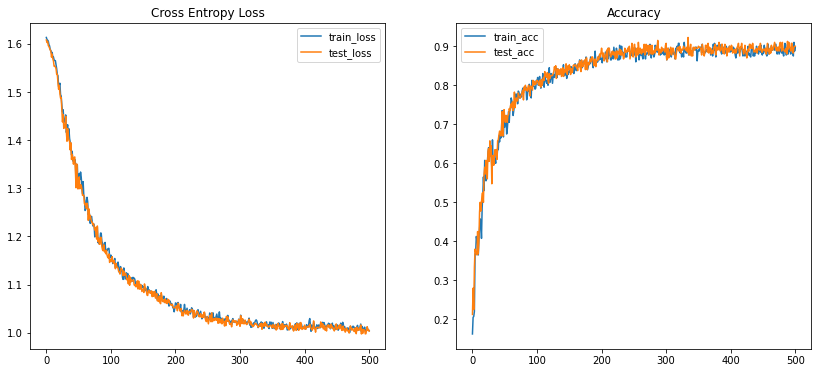

In [20]:
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

axs[0].plot(train_loss_per_ep, label="train_loss")
axs[0].plot(test_loss_per_ep, label="test_loss")
axs[0].set_title("Cross Entropy Loss")
axs[0].legend()

axs[1].plot(train_acc_per_ep, label="train_acc")
axs[1].plot(test_acc_per_ep, label="test_acc")
axs[1].set_title("Accuracy")
axs[1].legend()

fig.show()

## References

<span id="cite-ntm"></span>
[1] Graves, A., Wayne, G., & Danihelka, I. (2014). Neural turing machines. *arXiv preprint arXiv:1410.5401.*

<span id="cite-one-shot-mann"></span>
[2] Santoro, A., Bartunov, S., Botvinick, M., Wierstra, D., & Lillicrap, T. (2016). One-shot learning with memory-augmented neural networks. *arXiv preprint arXiv:1605.06065.*

<span id="cite-omniglot"></span>
[3] Lake, B. M., Salakhutdinov, R., & Tenenbaum, J. B. (2015). Human-level concept learning through probabilistic program induction. *Science, 350*(6266), 1332-1338.